# Project 3: Denoising Diffusion (10 pts)

In this project, you will implement a denoising diffusion model to generate MNIST digits. The main idea is that a sufficiently powerful model learns to remove a bit of noise from a noisy sample. By iterating this model on a sample drawn from pure noise, one can generate samples from the training data distribution.

Generating reasonable samples with diffusion requires more advanced architectures than a simple MLP or CNN stack. To let you focus on implementing the core algorithm, we provide you with two model architectures:
1. A simple convolutional resnet
2. A small U-net variant

The former requires less compute and can get you some results even with CPU training in a few minutes. However, in our experience the resnet model will only generate strokes and blotches without the global structure of a digit because of the limited receptive field of the model. If you have a GPU or a bit more time on your hands, you can change the configuration to train a U-net. This takes roughly 5-10x as long but can yield some actual digits if you train it long enough.

**Note**: There was a crucial typo in one of the formulas on the slides. Make sure to download the most recent slides from moodle!

## Your task

Complete the missing code. Make sure that all the functions follow the provided specification, i.e. the output of the function exactly matches the description in the docstring. 

## General Remarks

Only functionality in the python files will be graded. Carefully read the method docstrings to understand the task, parameters and what output is expected.
Fill in the missing code at the markers in `ddpm.py`.
```python
###########################
# YOUR CODE HERE
###########################
```
Do not add or modify any code at other places in the notebook and python code files except where otherwise explicitly stated.
After you fill in all the missing code, restart the kernel and re-run all the cells in the notebook.

The following things are **NOT** allowed:
- Using additional `import` statements
- Using the `torch.distributions` package
- Copying / reusing code from other sources (e.g. code by other students)

If you plagiarise even for a single project task, you won't be eligible for the bonus this semester.

## Task 1: Beta Schedule (2pt)

Your first task is to implement a beta schedule in the `__init__` method of the DDPM class, i.e. a sequence of non-decreasing $0 < \beta_i < 1, i = 0, \ldots, N - 1$. A reasonable default is a linear increase from `1e-4` to `2e-2` as proposed in the [original DDPM paper](https://arxiv.org/abs/2006.11239). Additionally, you have to compute the derived variables $\alpha$, $\bar{\alpha}$ and $\tilde{\beta}$. Feel free to compute other coefficients for your later computations here but you should implement and use at least these 4.

## Task 2: Simplified Loss (2pt)

Here, you have to implement the simplified loss from slide 16 in the method `simplified_loss`.

**Note**: The DDPM implementation works with integer noise levels `n` but the models work best with a normalized noise level between $0$ and $1$. So remember to normalize the noise level before calling the model.

This already gives us everything we need to train the model. The next two tasks yield support routines for the sampling procedure in the final task.

## Task 3: Compute $x_0$ from $z_n$ and $\varepsilon$ (2pt)

Given a sample $z_n$ and (an estimate of) $\varepsilon$, we want to find the $x_0$ that produced $z_n$. This will be necessary to sample $z_{n-1}$ in the sampling procedure.

Implement this computation in `estimate_x0`.

## Task 4: Sample from $q_{\varphi(x_0)}(z_{n-1} \mid z_n)$ (2pt)

Given $x_0$ and $z_n$, the method `sample_z_n_previous` should generate a sample from $q_{\varphi(x_0)}(z_{n-1} \mid z_n)$.

## Task 5: Iterative Sampling (2pt)

Finally, implement the iterative sampling procedure on slide 18. Remember to use the utility functions from the previous two tasks.

## Install required packages

Remove the `--quiet` flag to see installation progress.

In [1]:
!pip install --quiet -r requirements.txt

In [2]:
import numpy as np
import torch
from torchvision import datasets, transforms

from ddpm import DDPM
from visualization import visualize_dataset_mnist, visualize_mnist_samples

## Select an accelerator (CPU or GPU)

Select an accelerator for this project: If you have a GPU available, it will greatly speed up computations. It should however also be feasible to run this notebook entirely on a CPU.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda


## Load the MNIST dataset

In [4]:
batch_size = 128
tfs = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])
train_data = datasets.MNIST("./data", train=True, download=True, transform=tfs)
test_data = datasets.MNIST("./data", train=False, download=True, transform=tfs)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=device.type == "cuda")
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=device.type == "cuda")

## Visualize a few random samples from the dataset

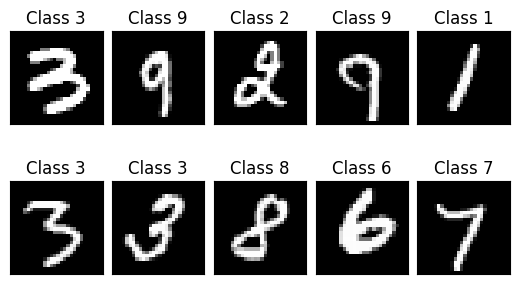

In [5]:
visualize_dataset_mnist(train_data);

## Model Training

In [6]:
max_epochs = 20
display_step = 100

ddpm = DDPM(N=1000, type="unet", hidden_dim=16, n_layers=2).to(device)
opt = torch.optim.Adam(ddpm.parameters())

In [20]:
for epoch in range(max_epochs):
    print(f"Epoch {epoch}")
    losses = []
    for ix, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)

        loss = ddpm.loss(x)

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
        if ix % display_step == 0:
            print(f"  loss = {loss.item():.2f}")
    print(f"  => mean(loss) = {np.mean(losses):.2f}")

Epoch 0
  loss = 2402.09
  loss = 2487.08
  loss = 2832.07
  loss = 2624.96
  loss = 2210.89
  => mean(loss) = 2635.05
Epoch 1
  loss = 3386.99
  loss = 3069.72
  loss = 2649.00
  loss = 2918.50
  loss = 2869.71
  => mean(loss) = 2643.67
Epoch 2
  loss = 2283.84
  loss = 2568.58
  loss = 2969.24
  loss = 2488.34
  loss = 2332.88
  => mean(loss) = 2611.38
Epoch 3
  loss = 2433.10
  loss = 2205.70
  loss = 2196.96
  loss = 2113.63
  loss = 2955.76
  => mean(loss) = 2604.38
Epoch 4
  loss = 2679.24
  loss = 2686.62
  loss = 2056.04
  loss = 2909.67
  loss = 2632.98
  => mean(loss) = 2630.54
Epoch 5
  loss = 2618.91
  loss = 2071.48
  loss = 3184.23
  loss = 2801.16
  loss = 2658.50
  => mean(loss) = 2592.97
Epoch 6
  loss = 2528.95
  loss = 2389.12
  loss = 2391.45
  loss = 2616.79
  loss = 2450.79
  => mean(loss) = 2591.56
Epoch 7
  loss = 2938.32
  loss = 2815.41
  loss = 2098.71
  loss = 2746.05
  loss = 2618.97
  => mean(loss) = 2607.29
Epoch 8
  loss = 3021.64
  loss = 2625.78
  loss

## Sampling

In [21]:
samples = ddpm.sample(20, device)

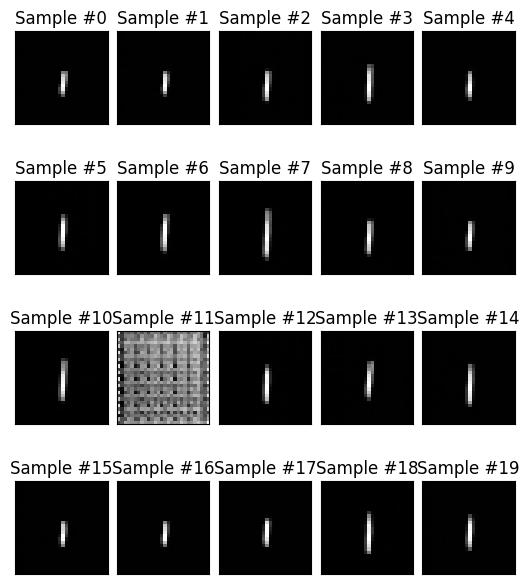

In [22]:
visualize_mnist_samples(samples);